# Location Intelligence Data Clustering

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from shapely.geometry import Point
import copy

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

from collections import Counter

from scipy.spatial import distance
from scipy.cluster import hierarchy
from sklearn.neighbors import NearestNeighbors

import geopandas as gpd

In [3]:
X_train = pd.read_csv('./DATA/X_train.csv')
X_val = pd.read_csv('./DATA/X_val.csv')
X_train_lat_long = pd.read_csv('./DATA/X_train_lat_long.csv')
X_val_lat_long = pd.read_csv('./DATA/X_val_lat_long.csv')

## Modelling

In [4]:
def metrics_plots(X, max_k=10):
    score = []
    score_kmeans_s = []
    score_kmeans_c = []
    score_kmeans_d = []

    for k in range(2, max_k):
        kmeans = KMeans(n_clusters=k, random_state= 101)
        predictions = kmeans.fit_predict(X)
        score.append(kmeans.score(X))
        score_kmeans_s.append(silhouette_score(X, kmeans.labels_, metric='euclidean'))
        score_kmeans_c.append(calinski_harabasz_score(X, kmeans.labels_))
        score_kmeans_d.append(davies_bouldin_score(X, predictions))

    list_scores = [score, score_kmeans_s, score_kmeans_c, score_kmeans_d] 
    list_title = ['Within-cluster sum of squares', 'Silhouette Score', 'Calinski Harabasz', 'Davies Bouldin'] 
    for i in range(len(list_scores)):
        x_ticks = list(range(2, len(list_scores[i]) + 2))
        plt.plot(x_ticks, list_scores[i], 'bx-')
        plt.xlabel('k')
        plt.ylabel(list_title[i])
        plt.title('Optimal k')
        plt.show()

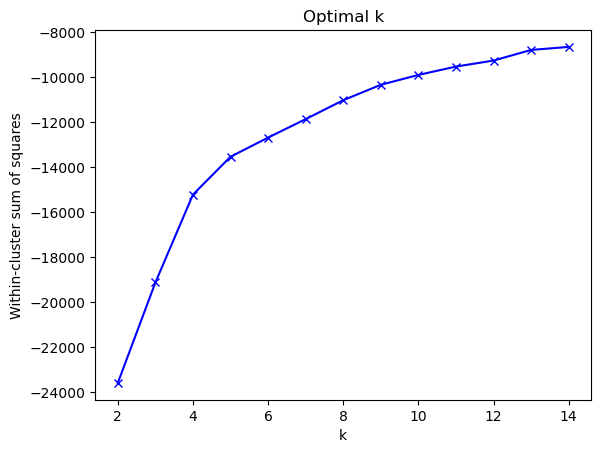

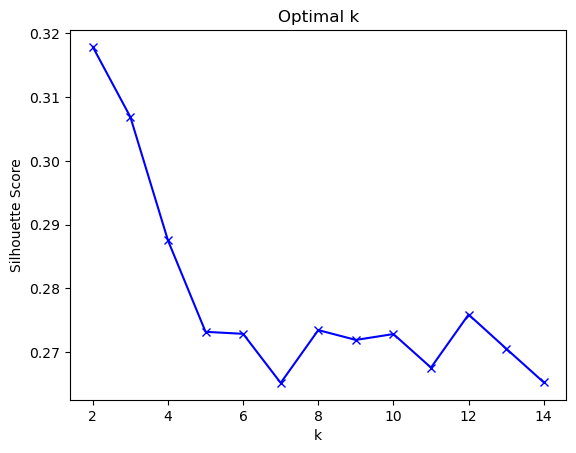

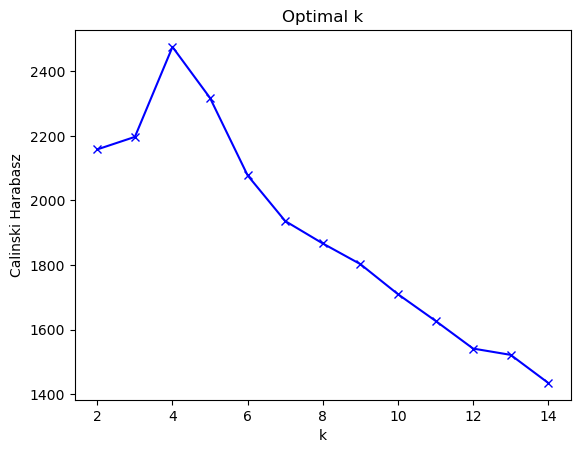

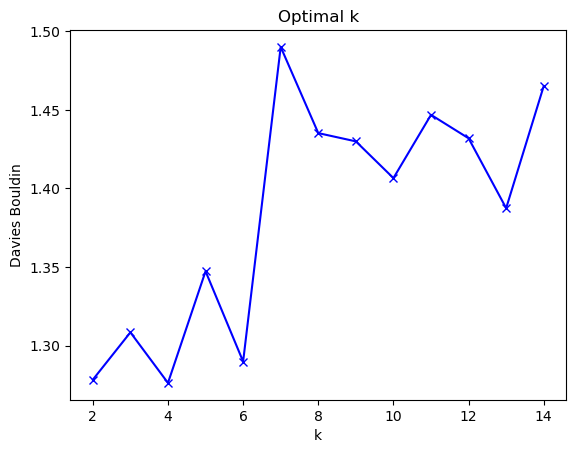

In [4]:
metrics_plots(X_train, max_k=15)

#### Results functions

In [5]:
def createColorMap(labels):
    unique_labels = np.unique(labels)
    cmap = cm.get_cmap('viridis', len(unique_labels))
    category_colors = {label: cmap(i) for i, label in enumerate(unique_labels)}
    return category_colors

def drawMap(data, labels, category_colors):
    gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(X_train_lat_long['longitude'], X_train_lat_long['latitude']))
    
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world = world[(world.name != "Antarctica")]
    

    fig, ax = plt.subplots(figsize=(15, 7))
    world.plot(ax=ax, color='lightgray', edgecolor='white')
    
    for label, color in category_colors.items():
        subset = gdf[labels == label]
        subset.plot(ax=ax, marker='o', color=color, markersize=9, label=label)
    
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=label,
                              markerfacecolor=color, markersize=9) 
                       for label, color in category_colors.items()]
    
    ax.legend(handles=legend_elements, loc='upper right', title='Cluster')
    
    plt.title('Businesses on World Map')
    plt.show()

def CountClusters(labels, category_colors):
    df = pd.DataFrame({"labels": labels})
    value_counts = df["labels"].value_counts()
        
    counts = value_counts.values
    clusters = value_counts.index

    plt.figure(figsize=(15, 6))
    bars = plt.bar(clusters, counts, color=[category_colors[c] for c in clusters])
    plt.title('Distribution of Clusters')
    plt.xlabel('Cluster Number')
    plt.ylabel('Number of Businesses')
    plt.show()

def calculateScores(data, labels):
    silhouette_avg = silhouette_score(data, labels)
    calinski_score = calinski_harabasz_score(data, labels)
    davies_bouldin = davies_bouldin_score(data, labels)
    Scores = {
    'Score name': ['Silhouette Score', 'Calinski-Harabaz Index', 'Davies-Bouldin Index'],
    'score value': [silhouette_avg, calinski_score, davies_bouldin]
    }

    df_scores = pd.DataFrame(Scores)
    return df_scores

#### PCA

In [6]:
pca = PCA()
pca.fit(X_train)
pca.explained_variance_ratio_

array([2.77228342e-01, 2.41131524e-01, 1.60940527e-01, 8.26602690e-02,
       6.95761509e-02, 5.74958805e-02, 3.78361980e-02, 3.03915649e-02,
       1.42946551e-02, 1.37633643e-02, 7.21493823e-03, 6.20337587e-03,
       8.61664156e-04, 3.68472631e-04, 3.30733684e-05, 3.90913231e-33,
       1.69090017e-33, 2.72783177e-34])

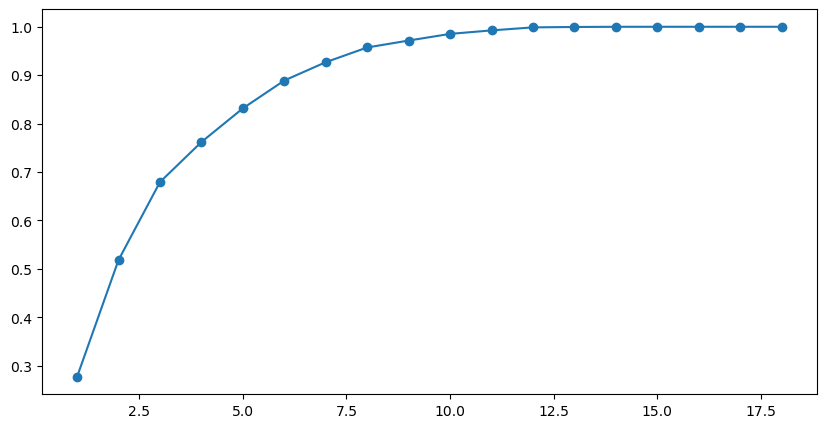

In [7]:
plt.figure(figsize = (10, 5))
plt.plot(range(1,19), pca.explained_variance_ratio_.cumsum(), marker = 'o')

In [8]:
pca = PCA(n_components=7)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)

In [9]:
X_val_pca = pca.transform(X_val)

#### KMeans

In [9]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_train_pca)
labels = kmeans.predict(X_train_pca)

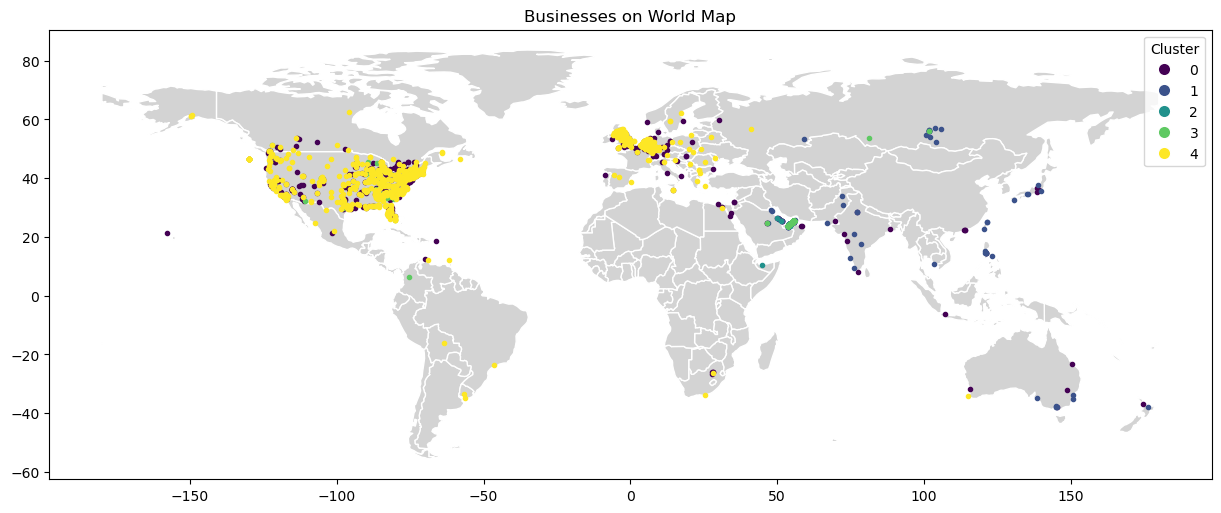

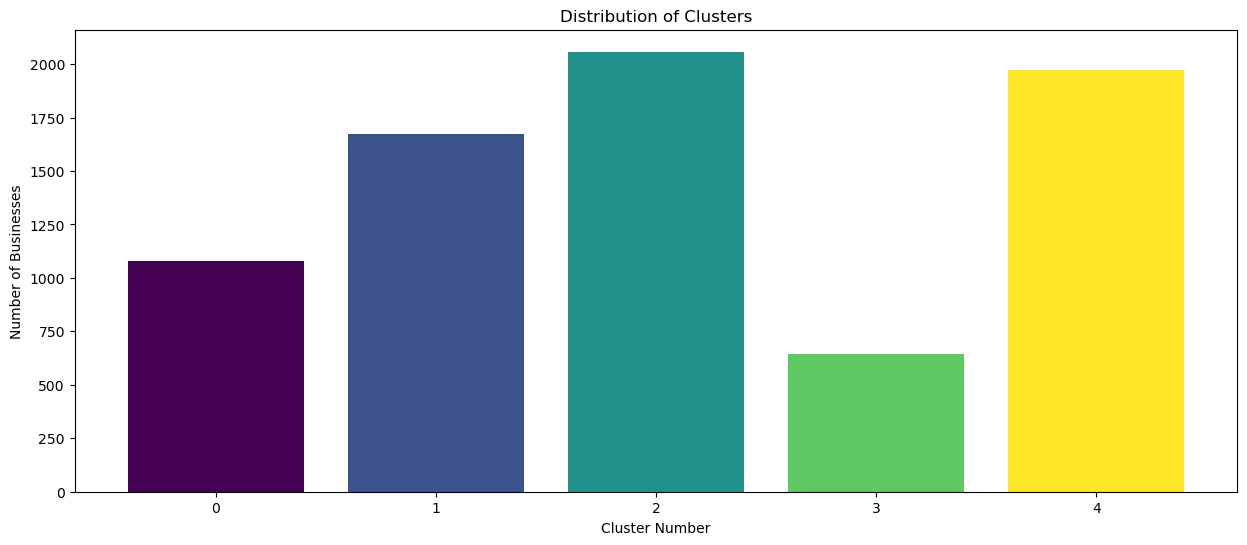

In [10]:
category_colors = createColorMap(labels)
drawMap(X_train_pca, labels, category_colors)
CountClusters(labels, category_colors)

In [11]:
calculateScores(X_train_pca, labels_kmeans)

Score name  score value
0        Silhouette Score     0.305531
1  Calinski-Harabaz Index  2769.311557
2    Davies-Bouldin Index     1.204398

In [12]:
labels = kmeans.predict(X_val_pca)
calculateScores(X_val_pca, labels)

Score name  score value
0        Silhouette Score     0.299523
1  Calinski-Harabaz Index  1161.897084
2    Davies-Bouldin Index     1.237226

#### KMedoids

In [77]:
medoids_model = KMedoids(n_clusters=5, random_state=0)
medoids_model.fit(X_train_pca)
labels = medoids_model.predict(X_train_pca)

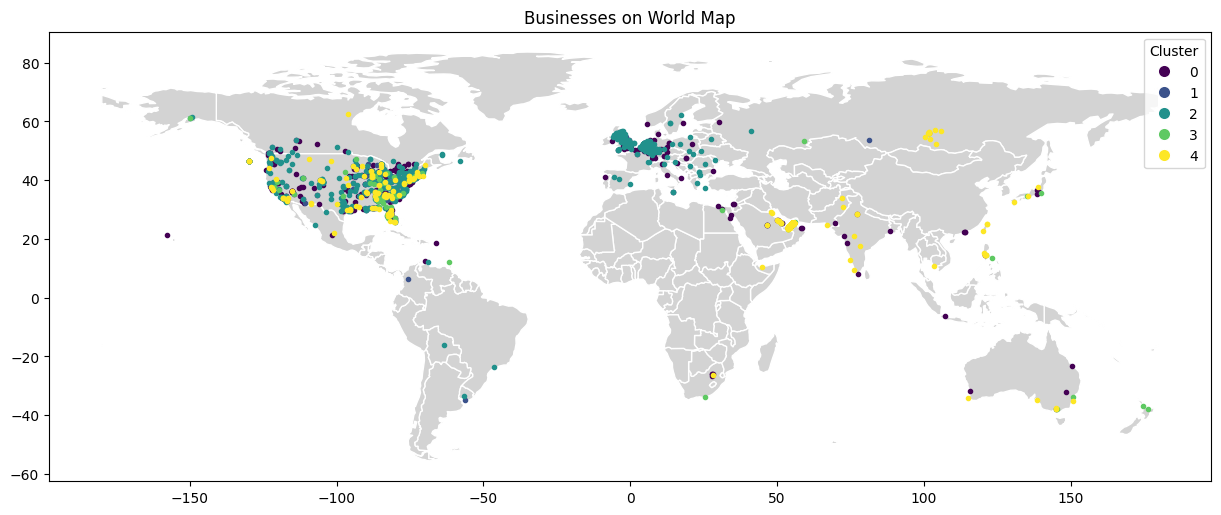

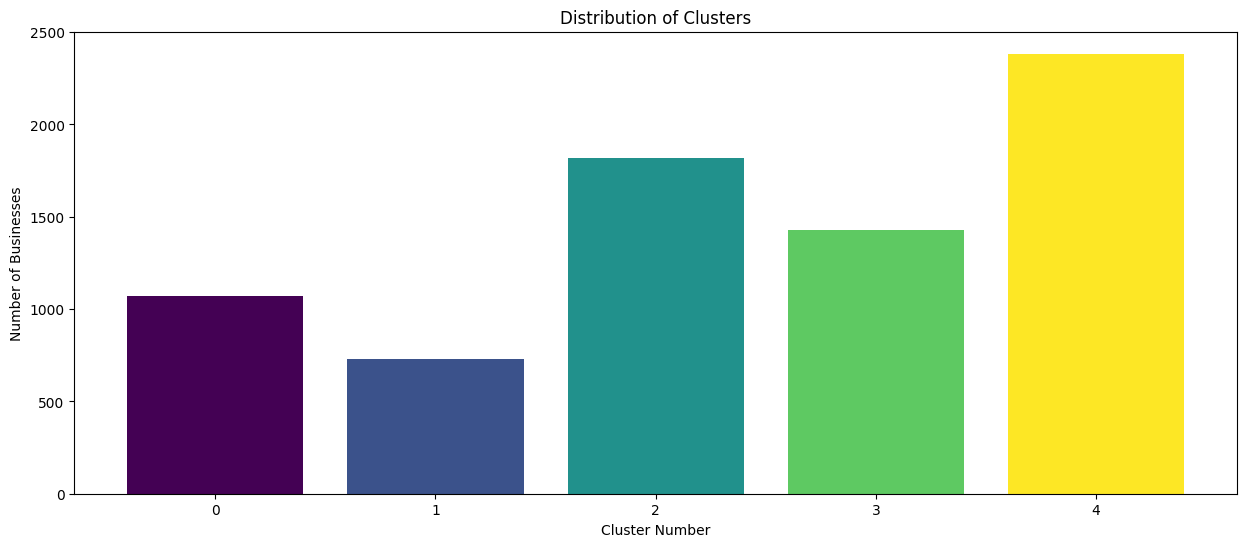

In [78]:
category_colors = createColorMap(labels)
drawMap(X_train_pca, labels, category_colors)
CountClusters(labels, category_colors)

In [79]:
calculateScores(X_train_pca, labels)

Score name  score value
0        Silhouette Score     0.219552
1  Calinski-Harabaz Index  2350.689896
2    Davies-Bouldin Index     1.641599

In [80]:
labels = medoids_model.predict(X_val_pca)
calculateScores(X_val_pca, labels)

Score name  score value
0        Silhouette Score     0.217005
1  Calinski-Harabaz Index   993.019666
2    Davies-Bouldin Index     1.657660

### Hierarchic models

In [74]:
def linkageGraph(data, method):
    Z = hierarchy.linkage(data, method=method)
    plt.figure(figsize=(10, 20), dpi= 200, facecolor='w', edgecolor='k')
    hierarchy.dendrogram(Z)
    plt.show()
    return Z

#### Single Linkage

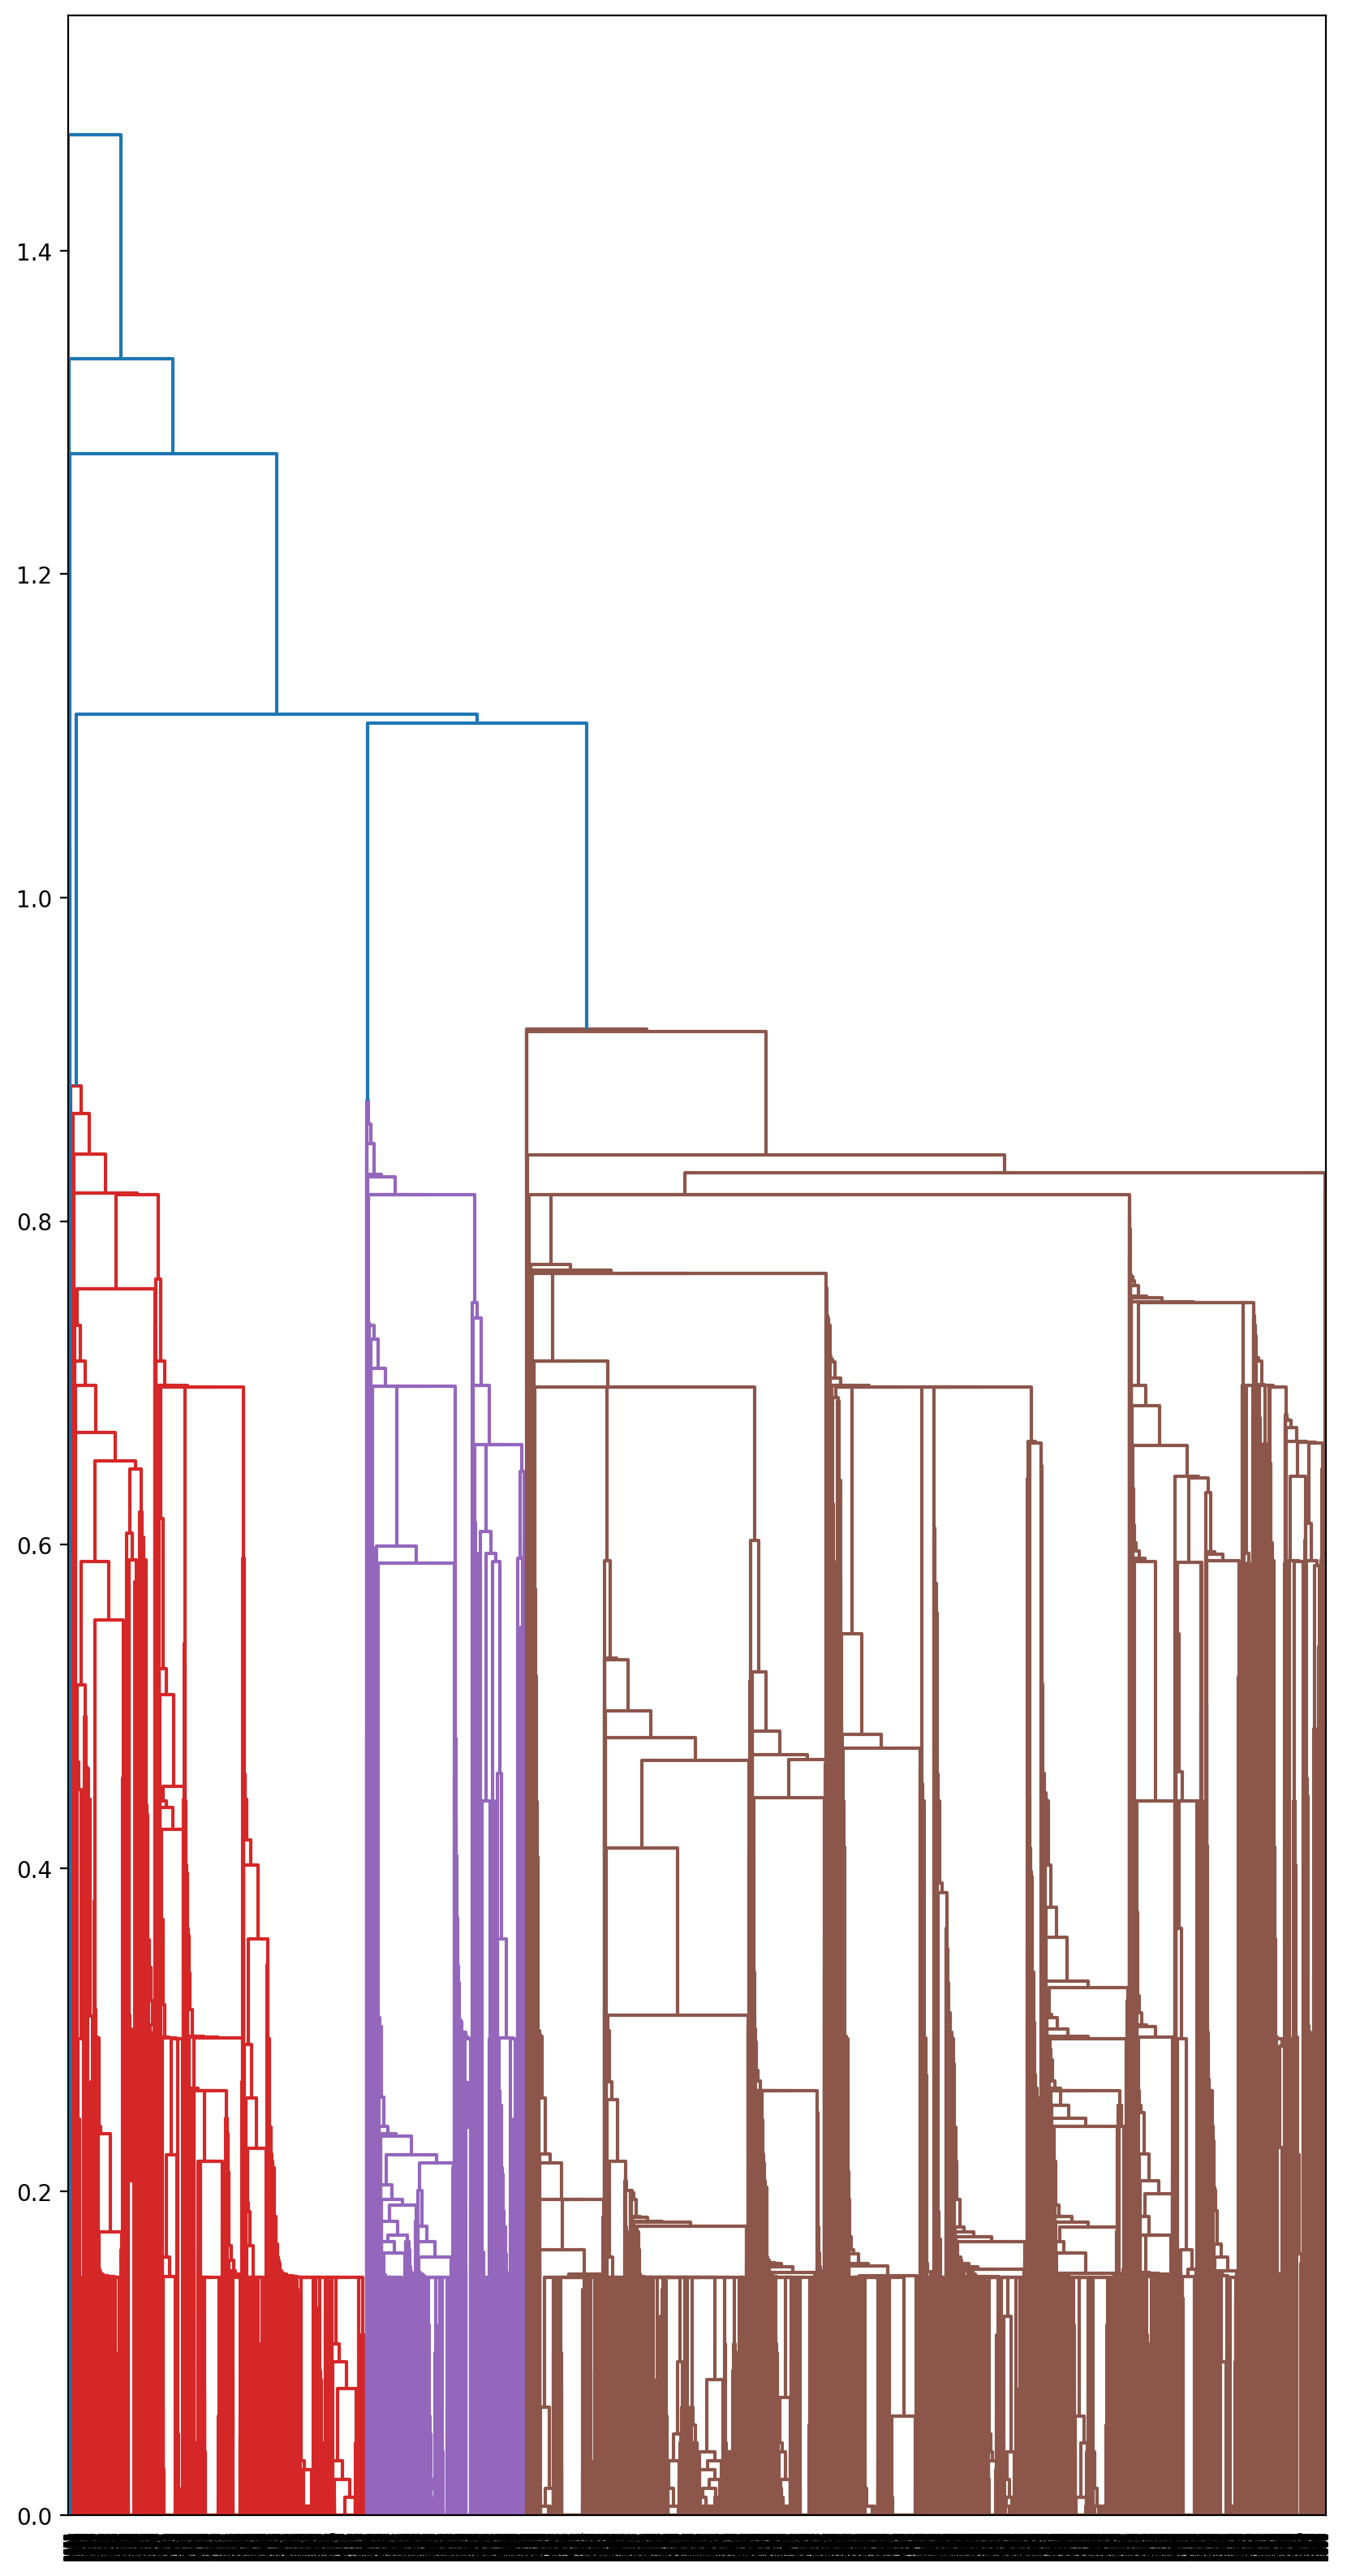

In [17]:
Z = linkageGraph(X_train_pca, 'single')

In [81]:
model = AgglomerativeClustering(n_clusters=None, linkage='single', distance_threshold=1.1)
labels = model.fit_predict(X_train_pca)

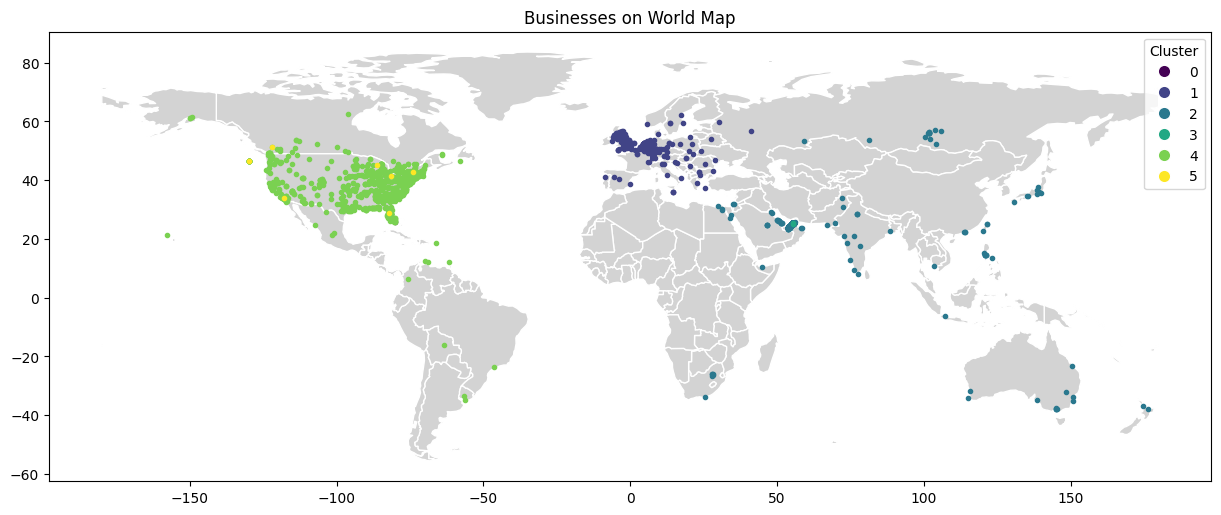

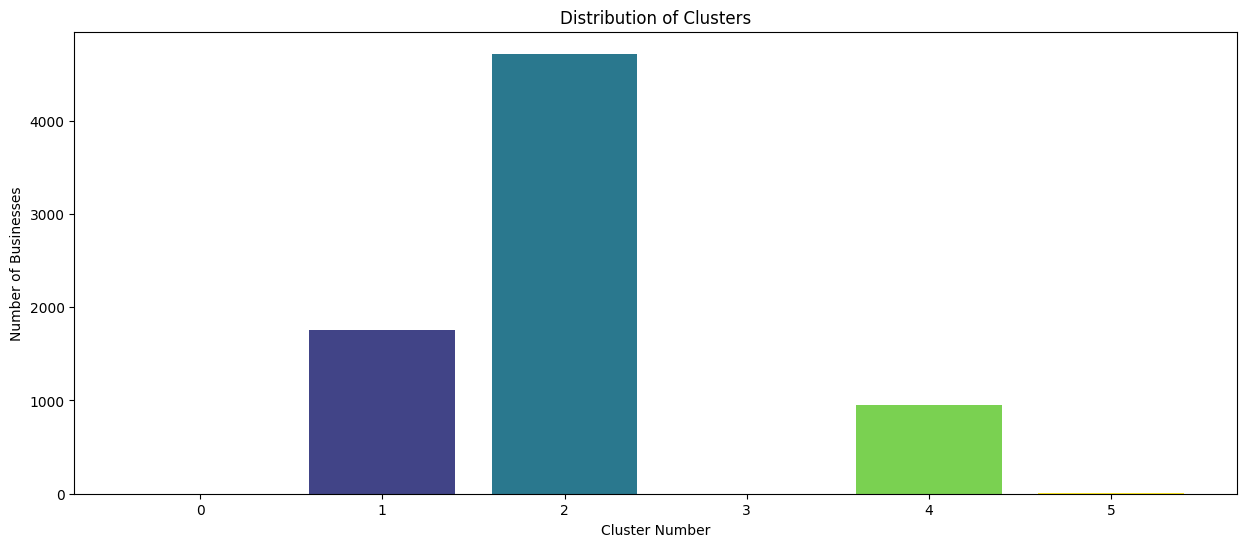

In [82]:
category_colors = createColorMap(labels)
drawMap(X_train_pca, labels, category_colors)
CountClusters(labels, category_colors)

In [83]:
calculateScores(X_train_pca, labels)

Score name  score value
0        Silhouette Score     0.203169
1  Calinski-Harabaz Index   515.144756
2    Davies-Bouldin Index     1.126414

#### Complete Linkage

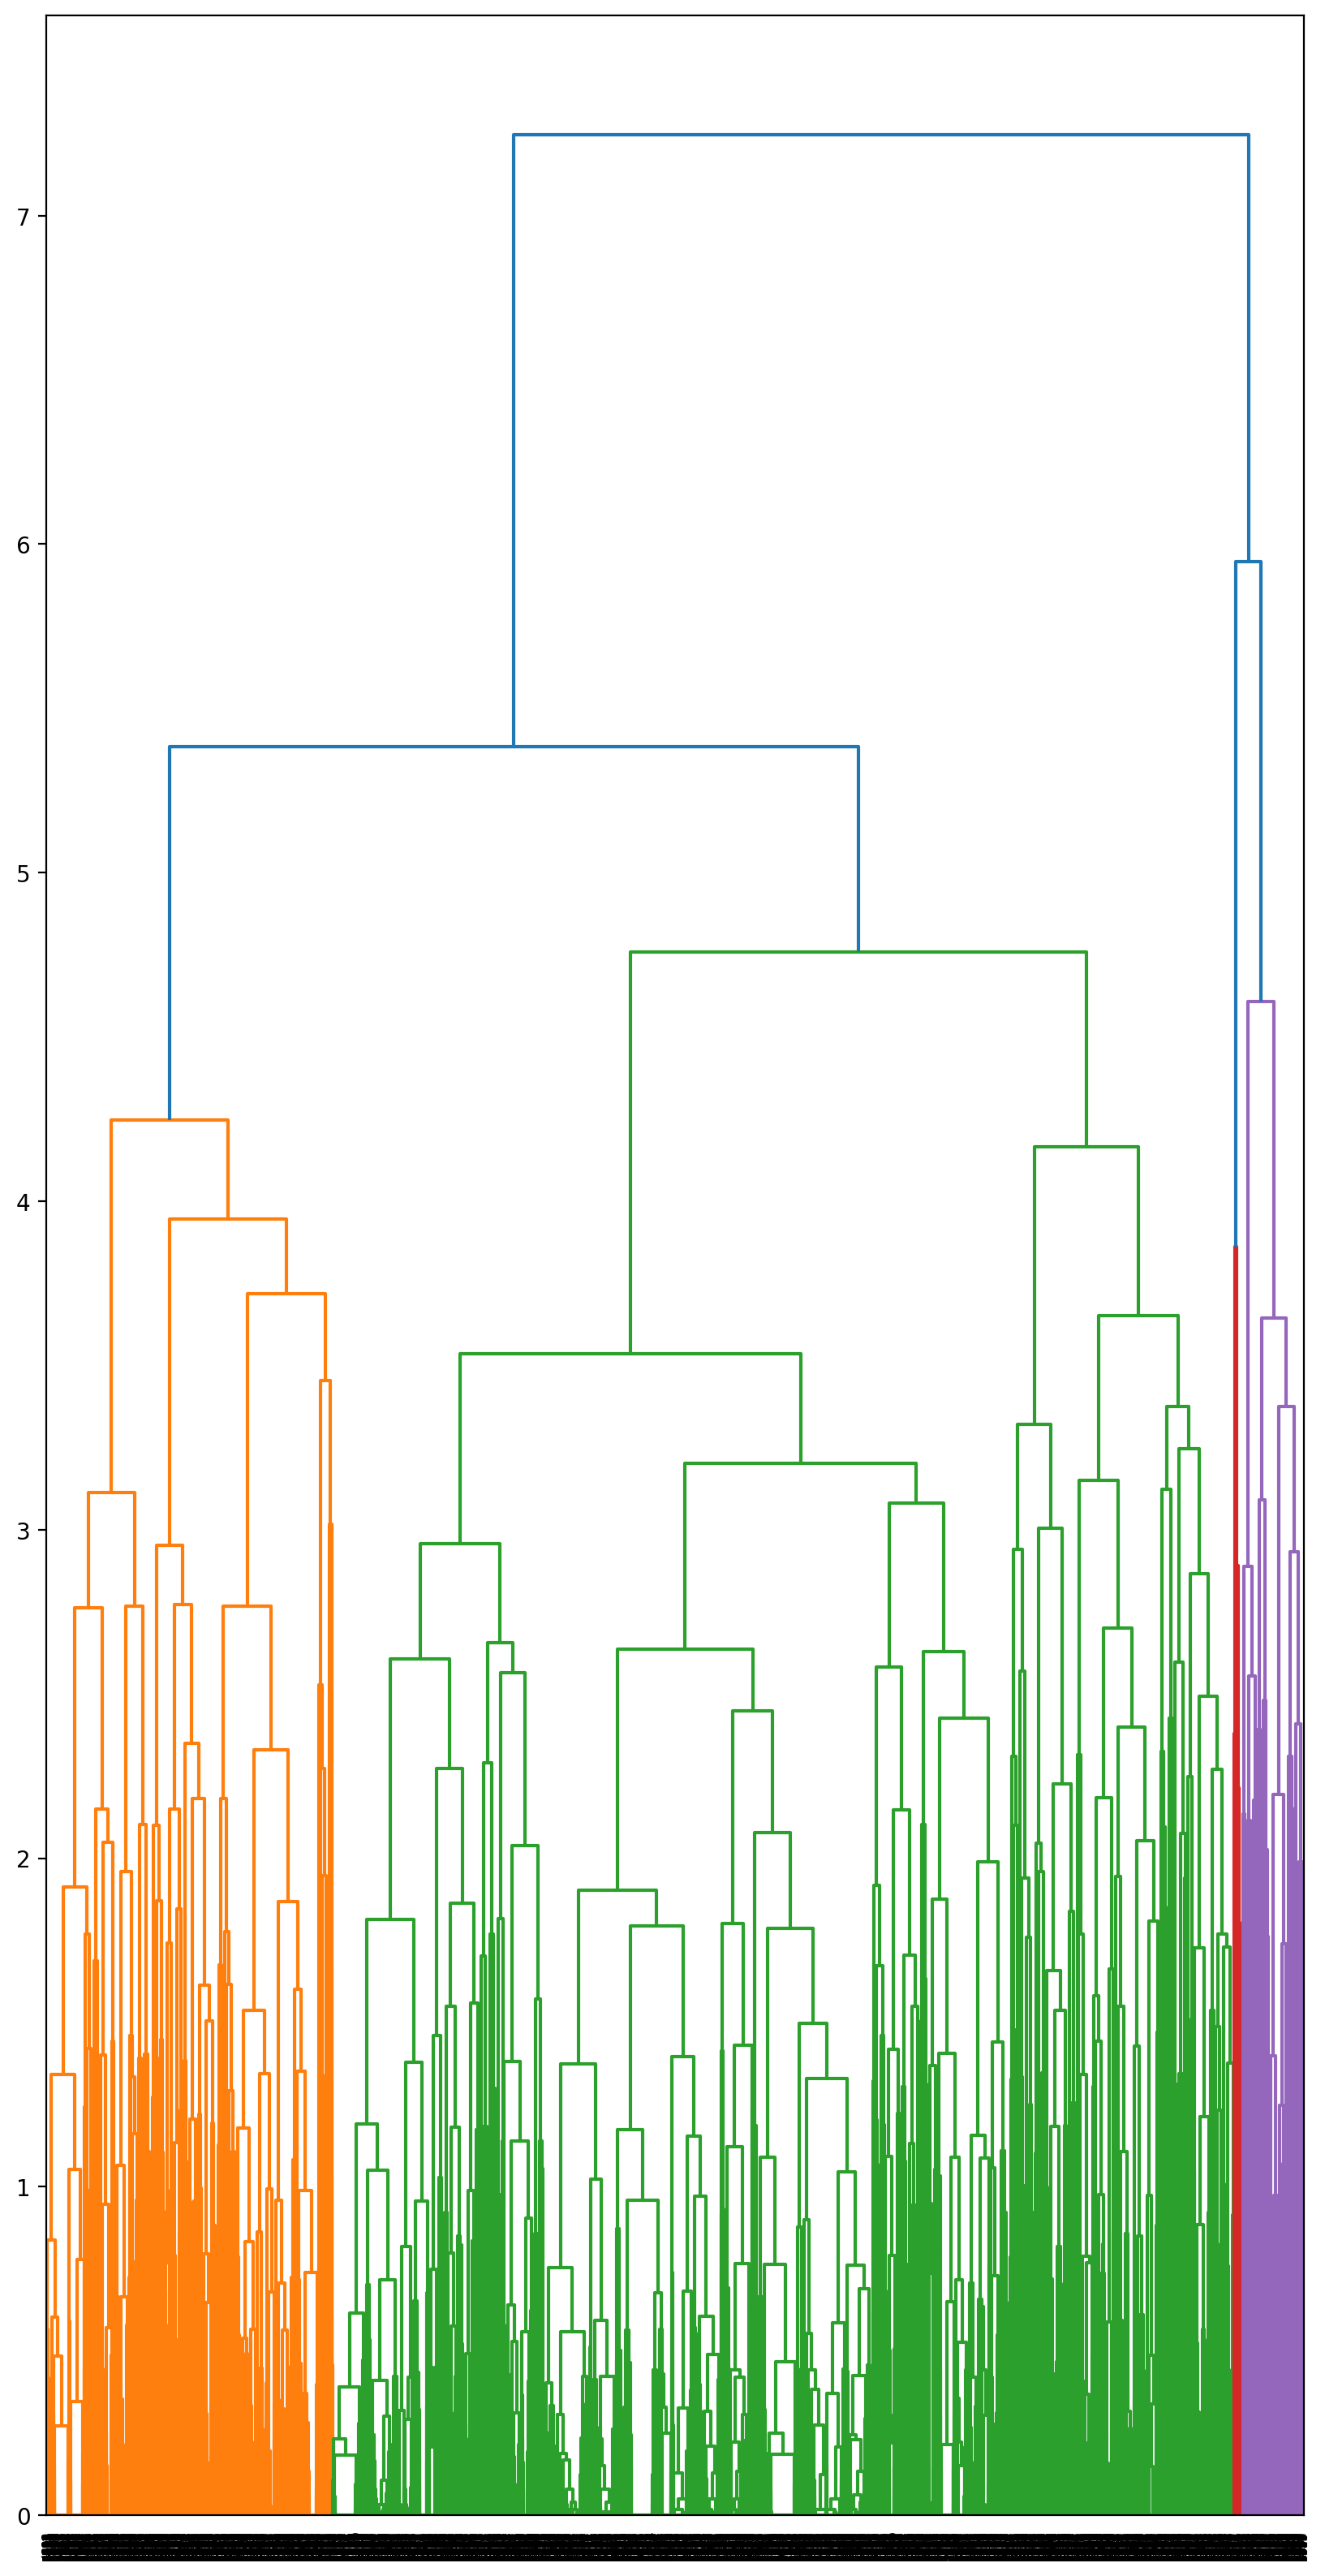

In [45]:
Z = linkageGraph(X_train_pca, 'complete')

In [24]:
model = AgglomerativeClustering(n_clusters=None, linkage='complete', distance_threshold=5)
labels = model.fit_predict(X_train_pca)

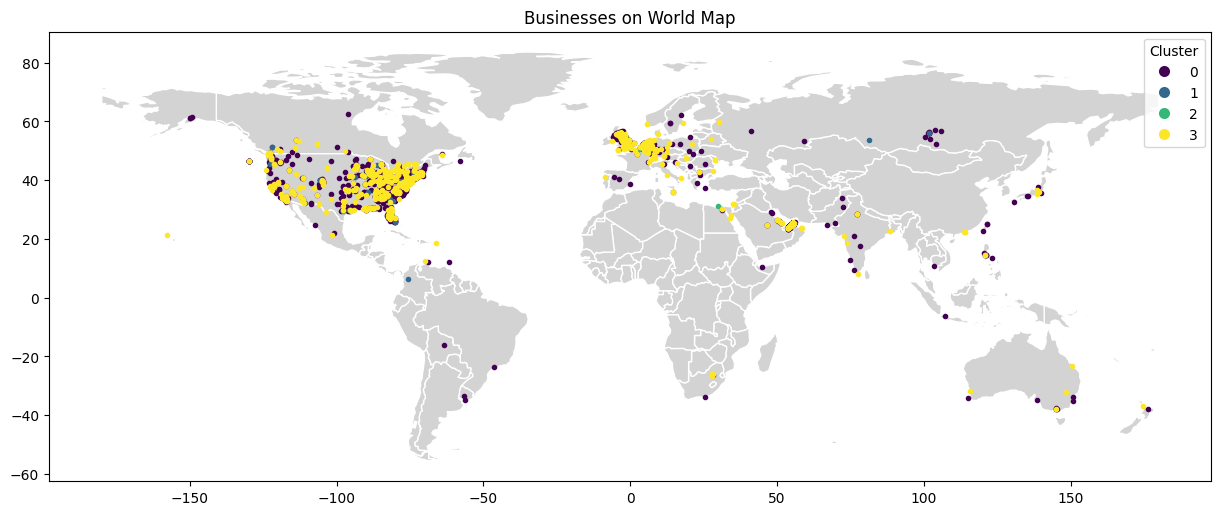

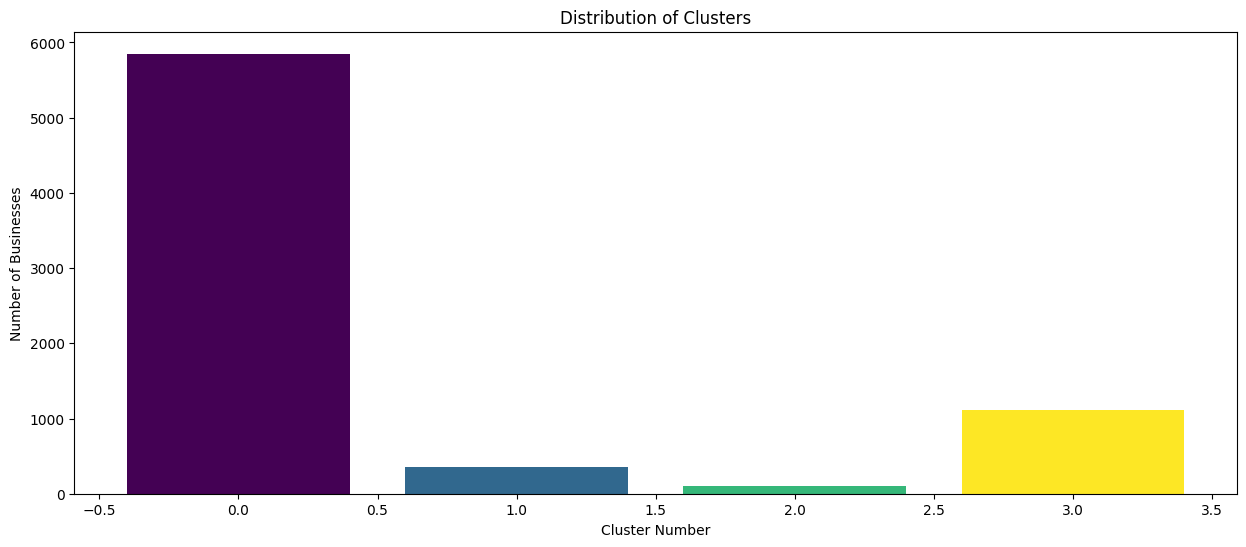

In [25]:
category_colors = createColorMap(labels)
drawMap(X_train_pca, labels, category_colors)
CountClusters(labels, category_colors)

In [26]:
calculateScores(X_train_pca, labels)

Score name  score value
0        Silhouette Score     0.301766
1  Calinski-Harabaz Index  1455.724647
2    Davies-Bouldin Index     1.382764

#### Average Linkage

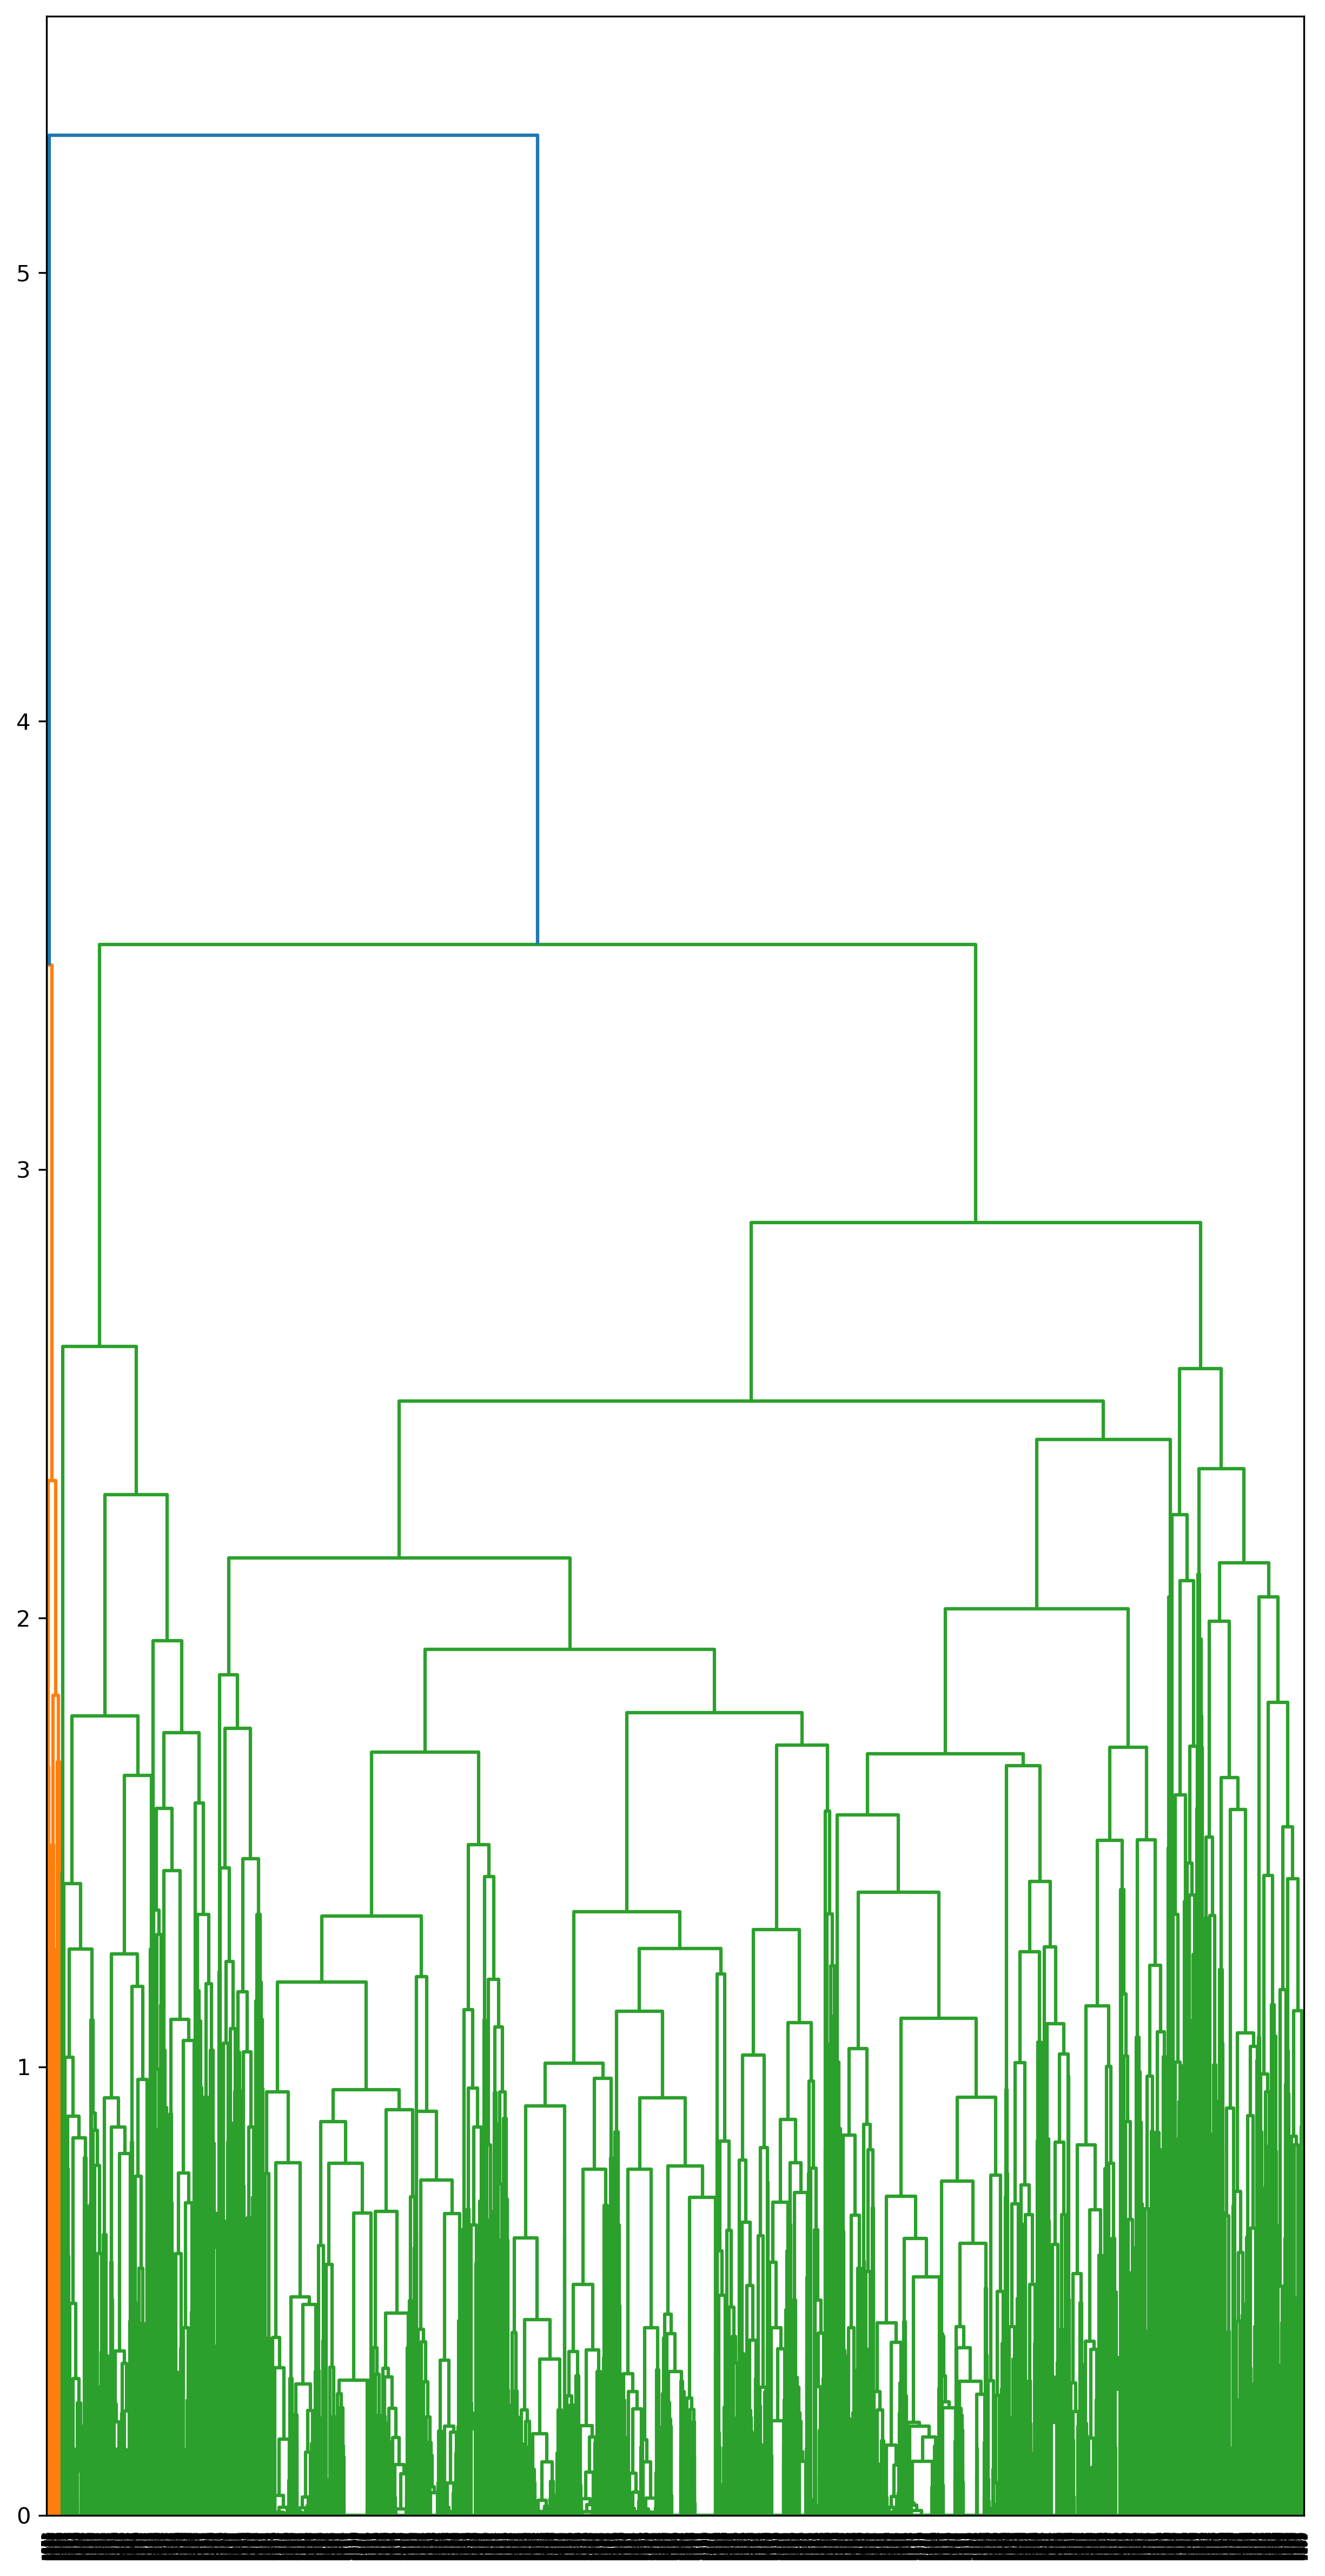

In [75]:
Z = linkageGraph(X_train_pca, 'average')

In [27]:
model = AgglomerativeClustering(n_clusters=None, linkage='average', distance_threshold=3)
labels = model.fit_predict(X_train_pca)

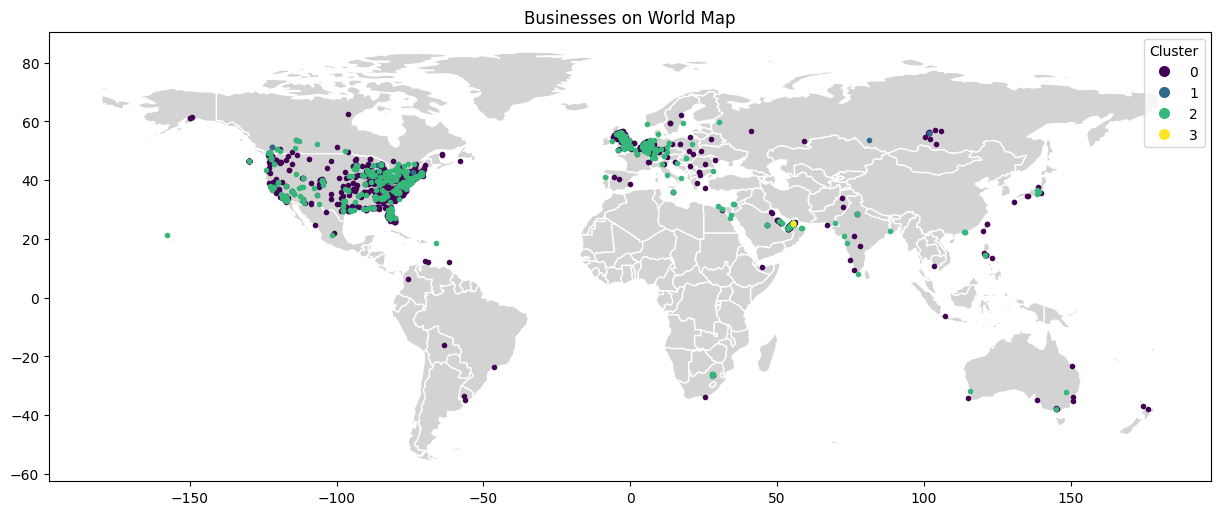

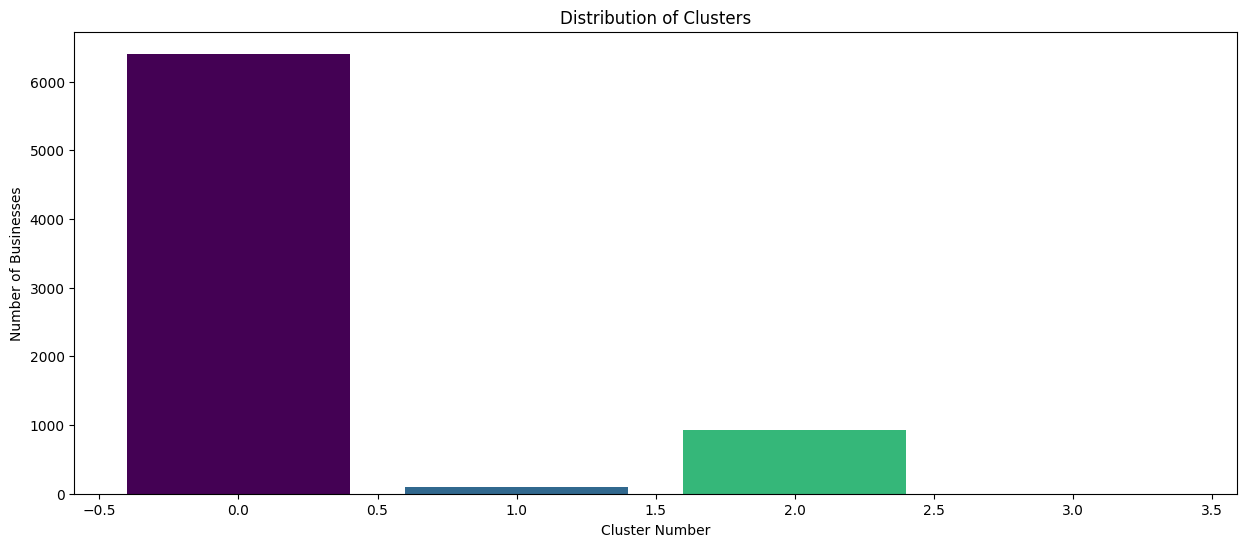

In [28]:
category_colors = createColorMap(labels)
drawMap(X_train_pca, labels, category_colors)
CountClusters(labels, category_colors)

In [29]:
calculateScores(X_train_pca, labels)

Score name  score value
0        Silhouette Score     0.352149
1  Calinski-Harabaz Index  1084.687786
2    Davies-Bouldin Index     0.815083

#### Ward's Linkage

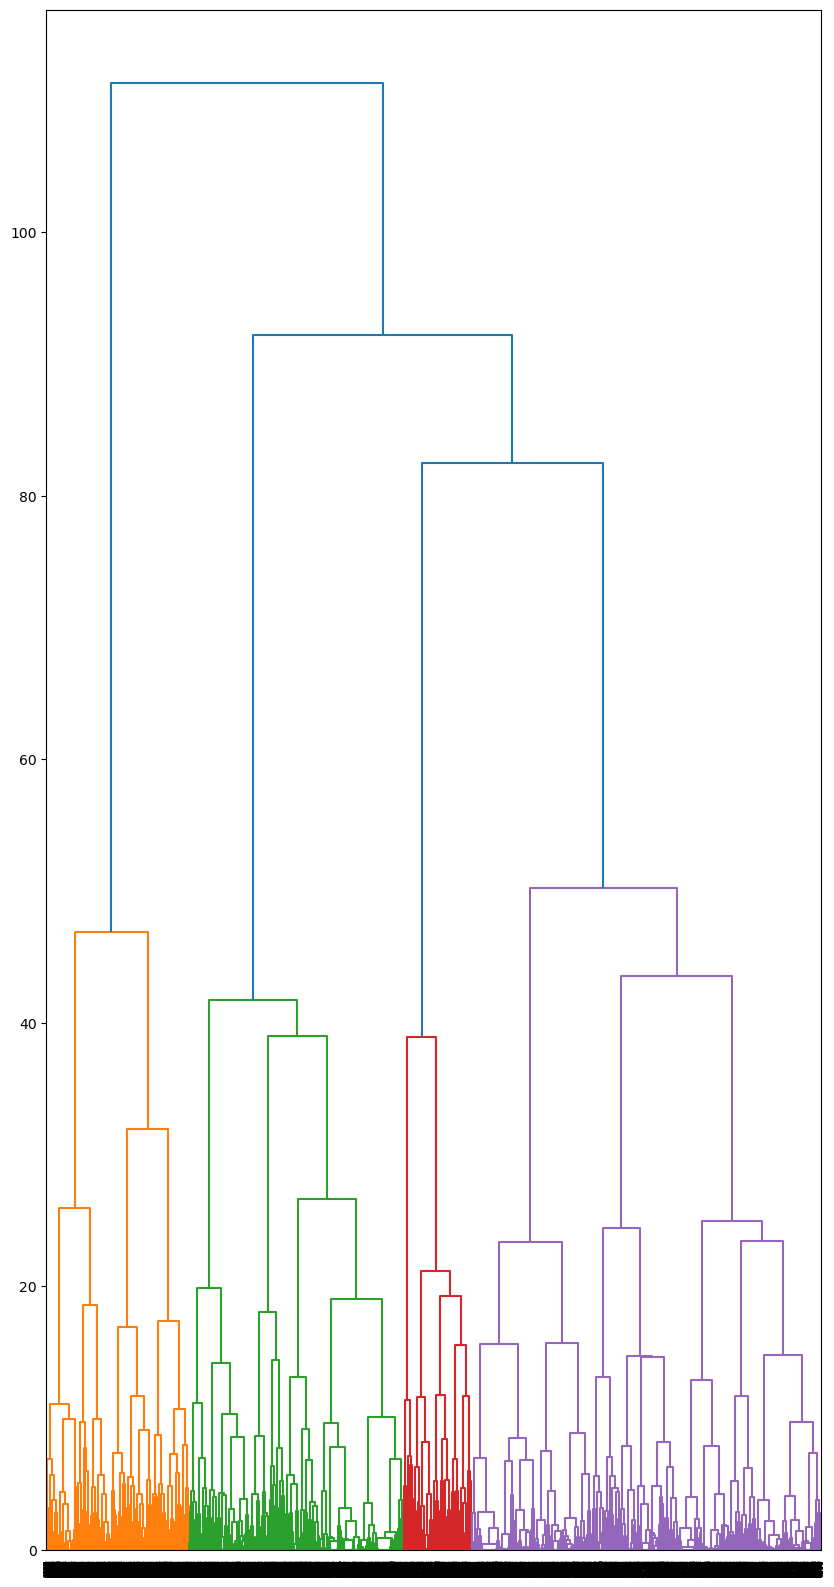

In [69]:
Z = linkageGraph(X_train_pca, 'ward')

In [70]:
model = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=60)
labels = model.fit_predict(X_train_pca)

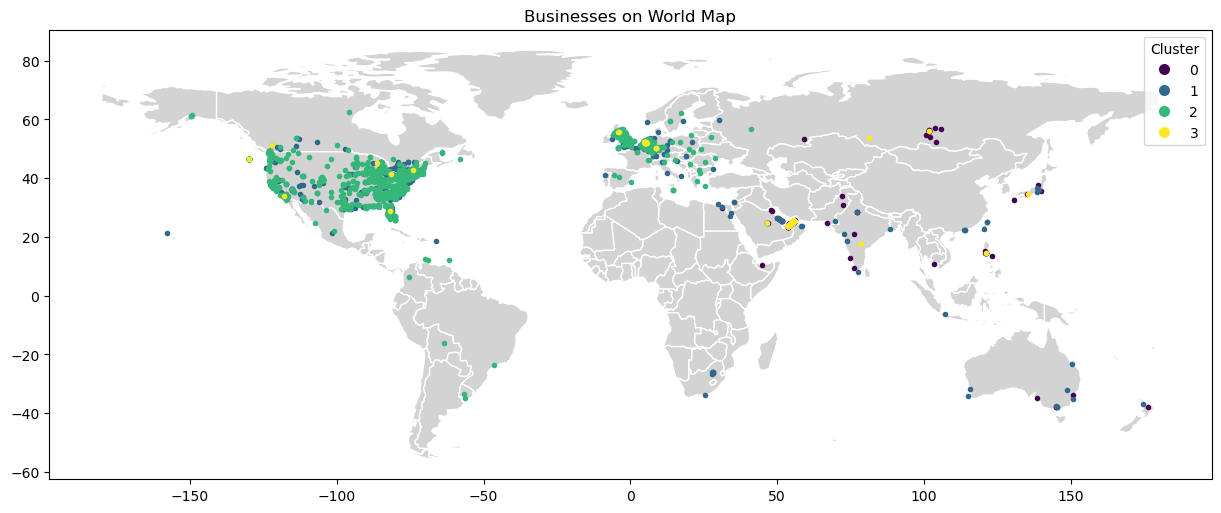

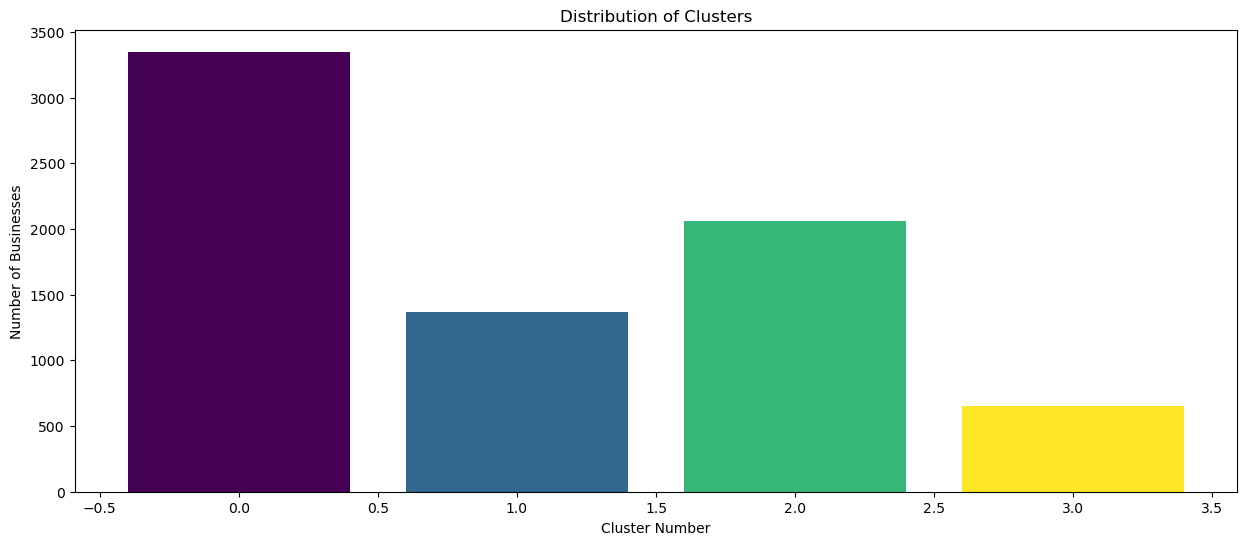

In [71]:
category_colors = createColorMap(labels)
drawMap(X_train_pca, labels, category_colors)
CountClusters(labels, category_colors)

In [72]:
calculateScores(X_train_pca, labels)

Score name  score value
0        Silhouette Score     0.287645
1  Calinski-Harabaz Index  2380.876503
2    Davies-Bouldin Index     1.261915

#### MiniBatchKMeans

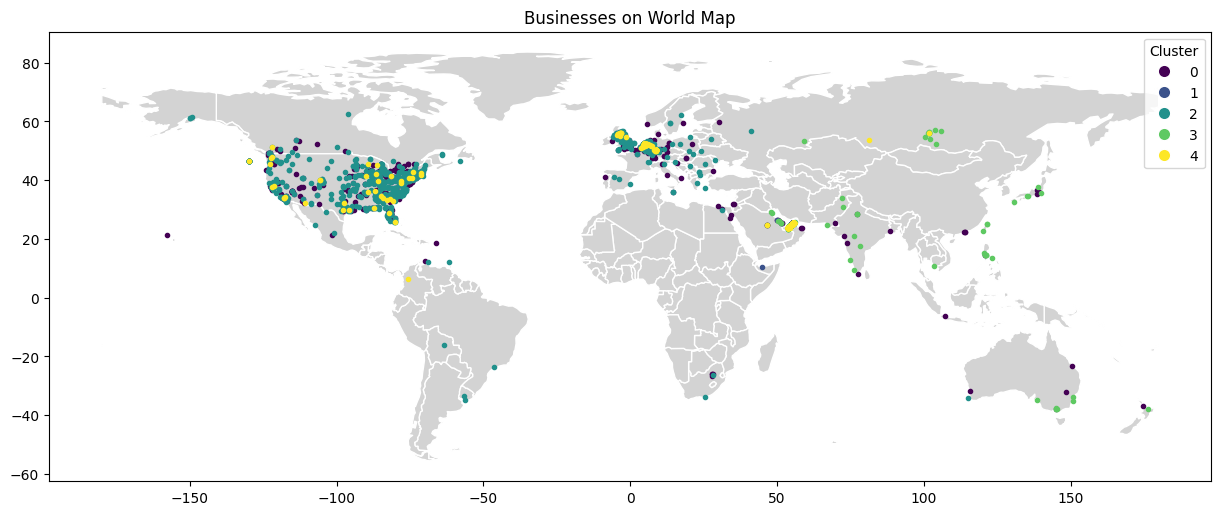

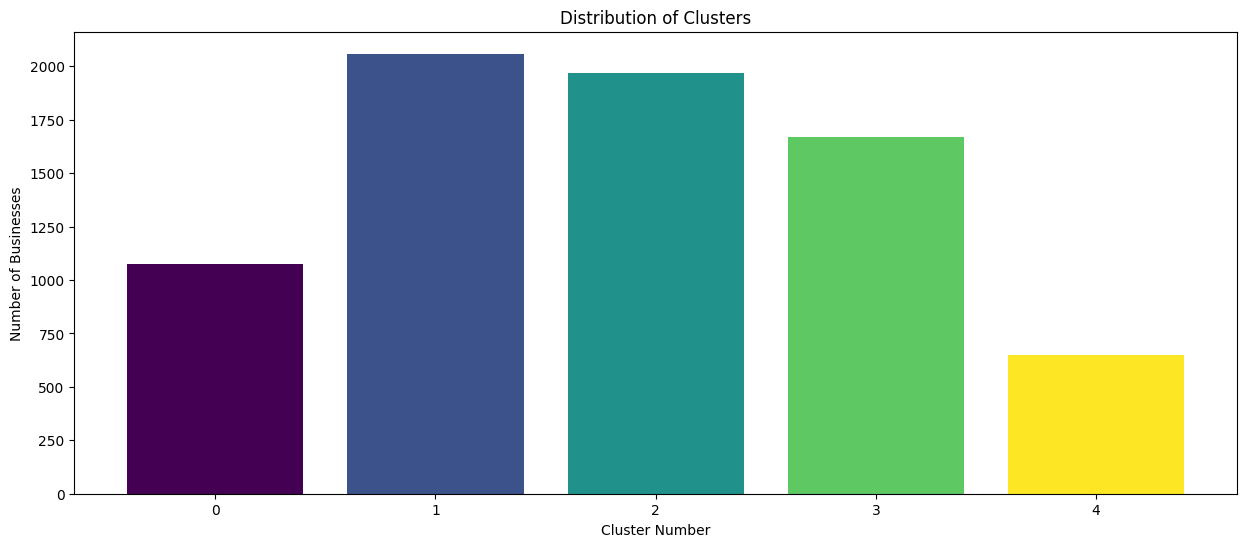

In [86]:
miniBatchKmeans = MiniBatchKMeans(n_clusters=5)
miniBatchKmeans.fit(X_train_pca)
labels = miniBatchKmeans.predict(X_train_pca)
category_colors = createColorMap(labels)
drawMap(X_train_pca, labels, category_colors)
CountClusters(labels, category_colors)

In [87]:
calculateScores(X_train_pca, labels)

Score name  score value
0        Silhouette Score     0.305583
1  Calinski-Harabaz Index  2768.732906
2    Davies-Bouldin Index     1.204097

In [88]:
labels = miniBatchKmeans.predict(X_val_pca)
calculateScores(X_val_pca, labels)

Score name  score value
0        Silhouette Score     0.299440
1  Calinski-Harabaz Index  1162.043599
2    Davies-Bouldin Index     1.234943

#### DBScan

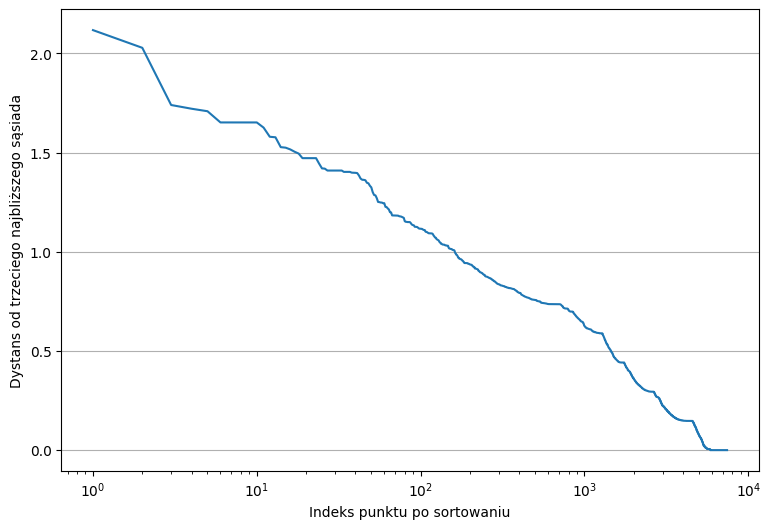

In [58]:
minPts = 14
nbrs = NearestNeighbors(n_neighbors=minPts).fit(X_train_pca)
distances, indices = nbrs.kneighbors(X_train_pca)
distanceDec = sorted(distances[:,minPts-1], reverse=True)
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(111)

plt.xlabel('Indeks punktu po sortowaniu')
plt.ylabel('Dystans od trzeciego najbliższego sąsiada')
ax1.plot(list(range(1,X_train_pca.shape[0]+1)), distanceDec)

plt.xscale('log')
plt.grid(axis='y')

plt.show()

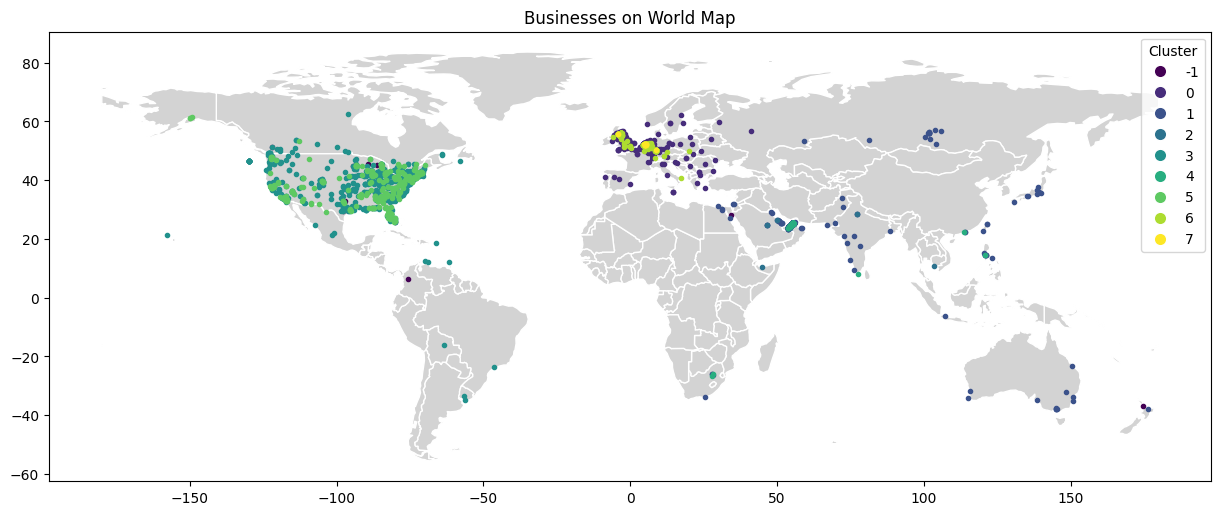

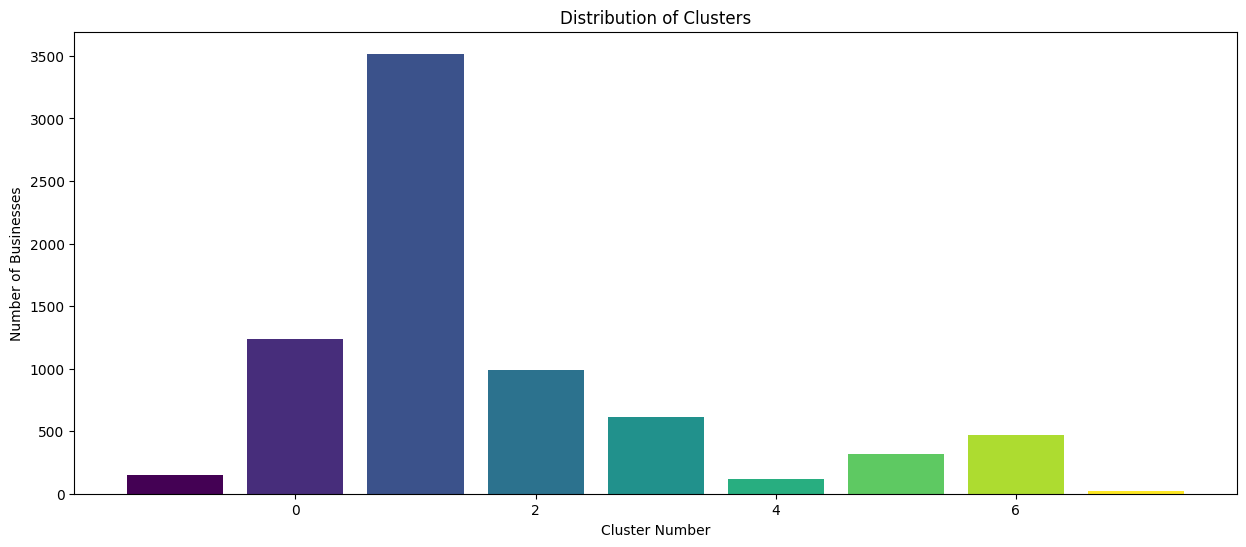

Score name  score value
0        Silhouette Score     0.139947
1  Calinski-Harabaz Index   621.679439
2    Davies-Bouldin Index     1.792859

In [57]:
dbs = DBSCAN(min_samples = 14, eps = 0.8)
dbs.fit(X_train_pca)
labels = dbs.labels_
category_colors = createColorMap(labels)
drawMap(X_train_pca, labels, category_colors)
CountClusters(labels, category_colors)
calculateScores(X_train_pca, labels)

#### Gaussian Mixture Models

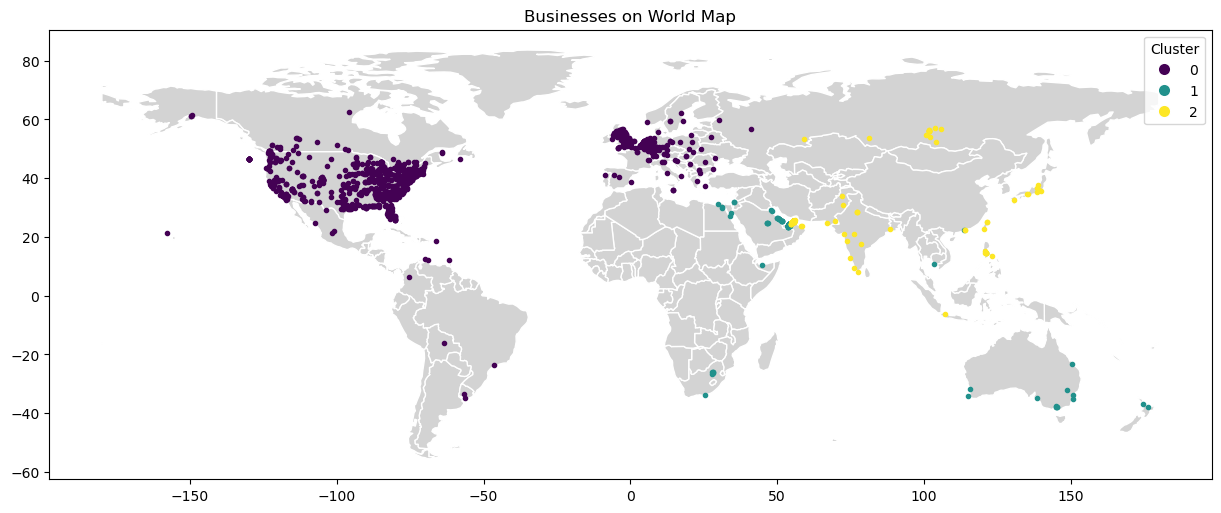

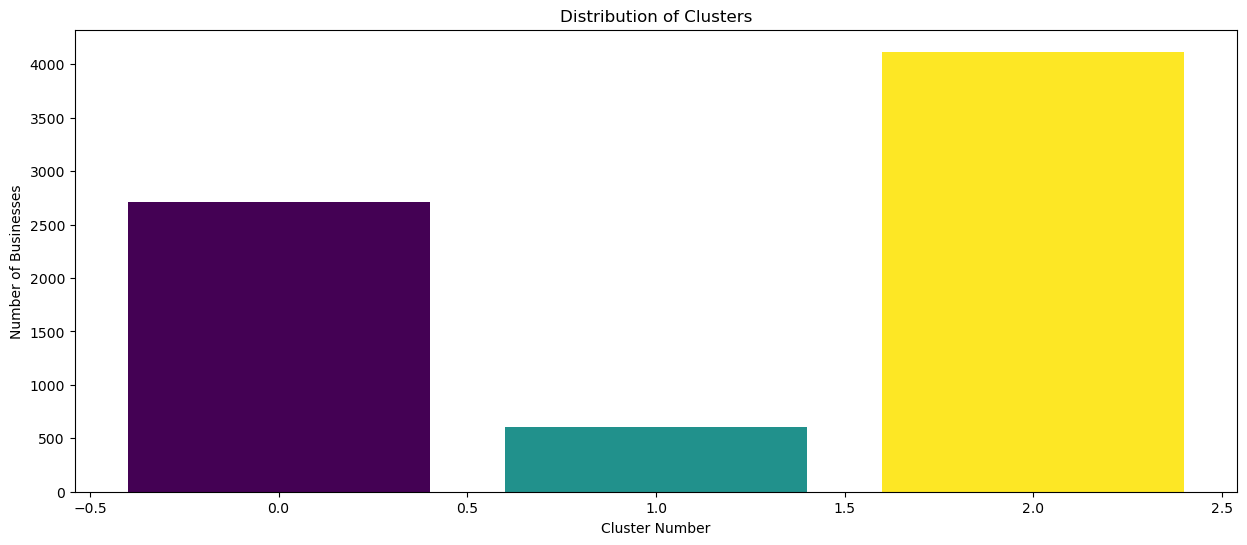

Score name  score value
0        Silhouette Score     0.120660
1  Calinski-Harabaz Index   947.990349
2    Davies-Bouldin Index     4.000534

In [12]:
gmm = GaussianMixture(n_components = 3)
gmm.fit(X_train_pca)
labels_gmm = gmm.predict(X_train_pca)
category_colors = createColorMap(labels_gmm)
drawMap(X_train_pca, labels_gmm, category_colors)
CountClusters(labels_gmm, category_colors)
calculateScores(X_train_pca, labels_gmm)

In [13]:
labels_gmm_val = gmm.predict(X_val_pca)
calculateScores(X_val_pca, labels_gmm_val)

Score name  score value
0        Silhouette Score     0.120867
1  Calinski-Harabaz Index   422.689053
2    Davies-Bouldin Index     4.000985

### Interpretation for best models

##### k-means

In [19]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_train_pca)
labels_kmeans = kmeans.predict(X_train_pca)
labels_kmeans_val = kmeans.predict(X_val_pca)

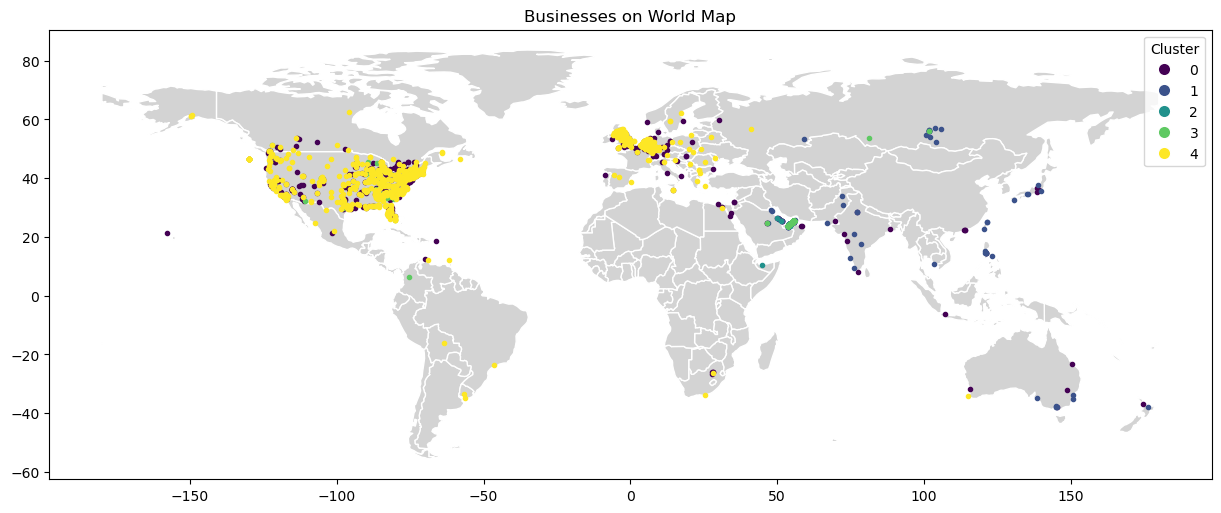

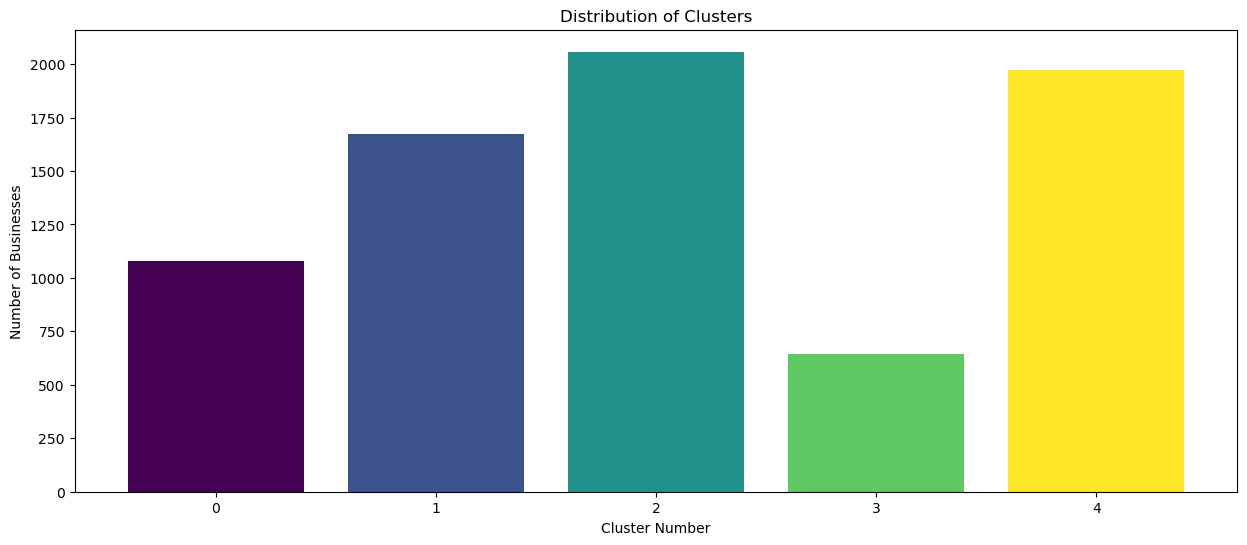

In [20]:
category_colors = createColorMap(labels_kmeans)
drawMap(X_train_pca, labels_kmeans, category_colors)
CountClusters(labels_kmeans, category_colors)

In [21]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, labels_kmeans)
labels_kmeans_pred = rf.predict(X_val)

accuracy = accuracy_score(labels_kmeans_val, labels_kmeans_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.99


In [22]:
importances = rf.feature_importances_
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

print(feature_importances)

                     Feature  Importance
0          num__review_count    0.253232
1                num__rating    0.178003
13        cat__cluster_geo_1    0.160070
15        cat__cluster_geo_3    0.113183
4        cat__continent_Asia    0.104198
14        cat__cluster_geo_2    0.101886
6      cat__continent_Europe    0.034554
12        cat__cluster_geo_0    0.011325
3     cat__continent_America    0.010677
17    remainder__has_website    0.009970
8        cat__cluster_type_1    0.005498
11       cat__cluster_type_4    0.004933
10       cat__cluster_type_3    0.004704
16       remainder__verified    0.003398
9        cat__cluster_type_2    0.002902
7        cat__cluster_type_0    0.000810
2      cat__continent_Africa    0.000376
5   cat__continent_Australia    0.000281


As we can see the most important feature in our model is related to rating.

In [23]:
X_train1 = X_train.copy()
X_train1['cluster'] = labels_kmeans

In [24]:
grouped_X_train1 = X_train1[['cat__cluster_type_0', 'cat__cluster_type_1', 'cat__cluster_type_2', 
                            'cat__cluster_type_3', 'cat__cluster_type_4', 'cluster']].groupby('cluster').sum()
print("\nGrouped and Summed DataFrame:")
print(grouped_X_train1)


Grouped and Summed DataFrame:
         cat__cluster_type_0  cat__cluster_type_1  cat__cluster_type_2  \
cluster                                                                  
0                        2.0                130.0                111.0   
1                       46.0                169.0                 46.0   
2                       29.0                556.0                 33.0   
3                       30.0                107.0                  3.0   
4                       90.0                390.0                 49.0   

         cat__cluster_type_3  cat__cluster_type_4  
cluster                                            
0                      120.0                716.0  
1                       11.0               1402.0  
2                       15.0               1425.0  
3                       17.0                486.0  
4                       45.0               1397.0  


##### Gaussian Mixture Models

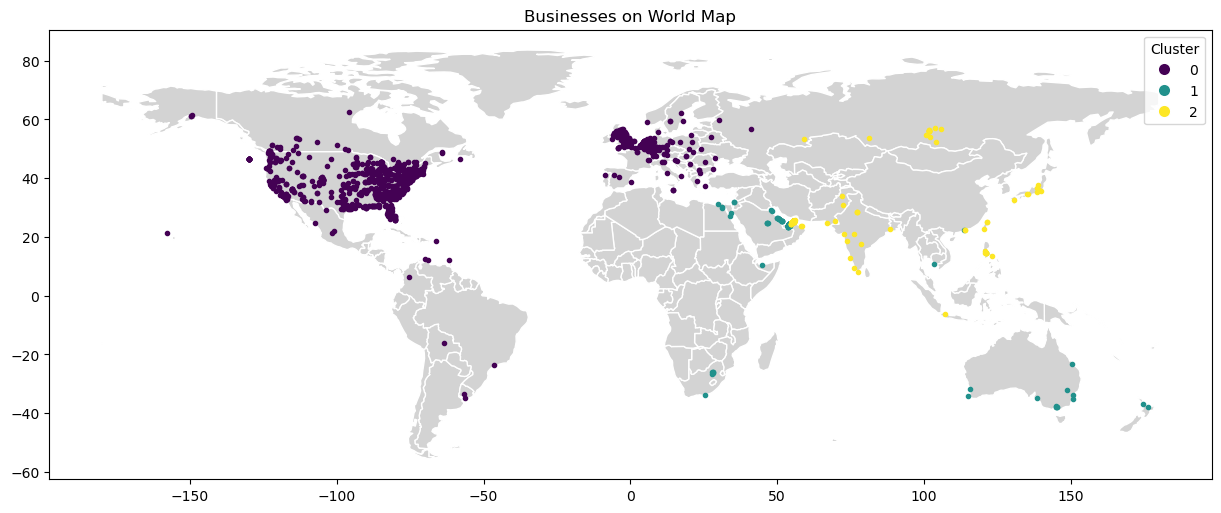

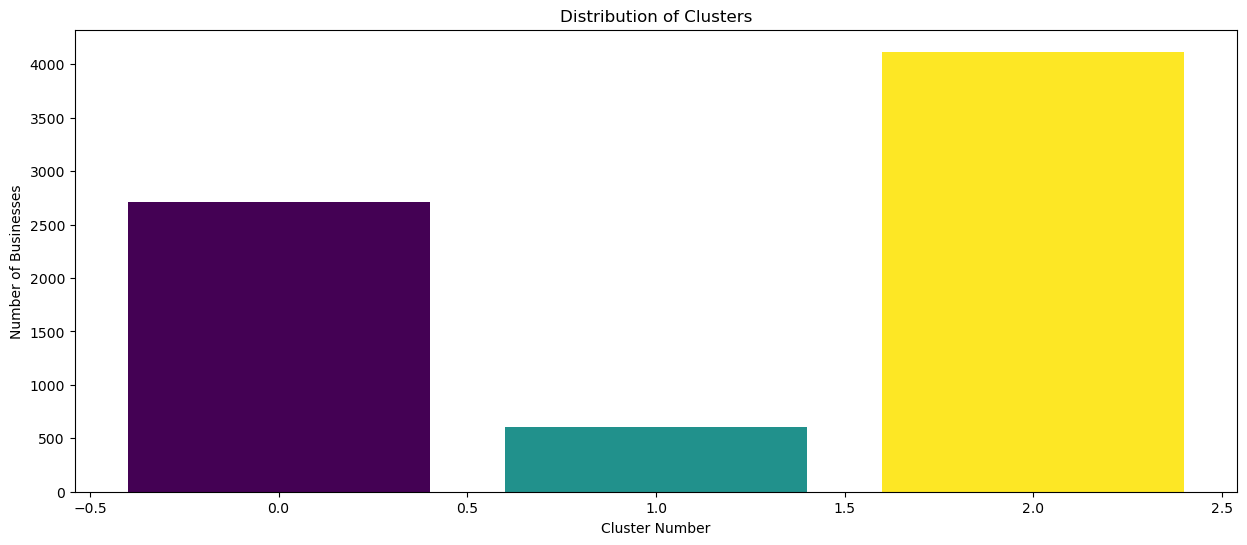

In [15]:
drawMap(X_train_pca, labels_gmm, category_colors)
CountClusters(labels_gmm, category_colors)

In [16]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, labels_gmm)
labels_gmm_pred = rf.predict(X_val)

accuracy = accuracy_score(labels_gmm_val, labels_gmm_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 1.00


In [17]:
importances = rf.feature_importances_
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

print(feature_importances)

                     Feature  Importance
4        cat__continent_Asia    0.270495
14        cat__cluster_geo_2    0.231331
6      cat__continent_Europe    0.124585
12        cat__cluster_geo_0    0.084741
15        cat__cluster_geo_3    0.052553
13        cat__cluster_geo_1    0.052431
3     cat__continent_America    0.050463
7        cat__cluster_type_0    0.029565
9        cat__cluster_type_2    0.026762
10       cat__cluster_type_3    0.025179
11       cat__cluster_type_4    0.018039
8        cat__cluster_type_1    0.013883
17    remainder__has_website    0.007689
0          num__review_count    0.006682
5   cat__continent_Australia    0.002185
1                num__rating    0.001637
2      cat__continent_Africa    0.000898
16       remainder__verified    0.000884


In Gaussian Mixture Models we can see tha most important features are related to location and types.

In [18]:
X_train2 = X_train.copy()
X_train2['cluster'] = labels_gmm
grouped_X_train2 = X_train2[['cat__cluster_type_0', 'cat__cluster_type_1', 'cat__cluster_type_2', 
                            'cat__cluster_type_3', 'cat__cluster_type_4', 'cluster']].groupby('cluster').sum()
print("\nGrouped and Summed DataFrame:")
print(grouped_X_train2)


Grouped and Summed DataFrame:
         cat__cluster_type_0  cat__cluster_type_1  cat__cluster_type_2  \
cluster                                                                  
0                      100.0                481.0                139.0   
1                       97.0                 53.0                103.0   
2                        0.0                818.0                  0.0   

         cat__cluster_type_3  cat__cluster_type_4  
cluster                                            
0                       99.0               1888.0  
1                      107.0                241.0  
2                        2.0               3297.0  
